# QDM-QPLAD EDA

This notebook is for exploring the Quantile Delta Mapping - Quantile Preserving Analog Downscaling method. This method of statistical downscaling, introduced in [Gergel et al. 2023](https://doi.org/10.5194/gmd-17-191-2024), is of interest to collaborators, and this notebook will attempt to implement this method as a proof of concept for our CMIP6 statistical downscaling goals.  

The code used to do it is in a fork of the `xclim` package developed by the team who created this method: [https://github.com/ClimateImpactLab/xclim](https://github.com/ClimateImpactLab/xclim). 

The [ClimateImpactLab/dodola](https://github.com/ClimateImpactLab/dodola) repo contains the python code used to actually perform the downscaling. 

### Environment

This is an experimental notebook, and will use their forked version of xclim. The spec for the environment used to run this notebook on a Chinook compute node can be found in the `cil_xclim_env.yml` file, and you can create the environment by running `conda env create -f cil_xclim_env.yml`. 

If you are unable to load the `xclim` functionality specific to the CIL-forked version, it's possible that `pip` installed from PyPI - I'm not sure how to set a github repo in the env spec file. Just install using `pip` like so:

```
pip install git+https://github.com/ClimateImpactLab/xclim@master
```

## Getting the grids straight

Here we will explore the regridding steps that need to happen to implement the full QDM-QPLAD method!

The Gergel methods perform 3 separate regriddings of the ERA5 data:

1. For QDM adjustment, it's regridded to the common grid using bilinear for temperature variables and conservative-area remapping for precipitation
2. For downscaling with QPLAD, it is regridded to a 0.25° × 0.25° regular lat–long grid
3. For QPLAD adjustment factors, common grid ERA5 is resampled (nearest neighbor regridded) to the 0.25° × 0.25° regular lat–long grid


Based on that, we will explore doing each of the following here with our 4km ERA5:

1. Regrid to common grid using bilinear for temperature variables and conservative-area remapping for precipitation
2. Regrid to target 12km 3338 grid
3. Resample common grid ERA5 via NN to target 12km 3338 grid

The target grid will simply be the 4km WRF grid but reprojected to 3338.

In [1]:
from pathlib import Path
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import rioxarray
import geopandas as gpd
from pyproj import CRS, Transformer, Proj
import xesmf as xe

In [2]:
era5_04km_dir = Path("/beegfs/CMIP6/wrf_era5/04km")

fp = era5_04km_dir.joinpath("2015/era5_wrf_dscale_4km_2015-12-26.nc")
ds = xr.open_dataset(fp)

### 1. Regrid ERA5 to common grid

We will use xESMF to regrid from the WRF grid to the regular lat-long grid. Since the WRF file already has lat / lon, we can use it as-is.

Load a comming grid CMIP6 file:

In [3]:
regrid_fp = Path(
    "/beegfs/CMIP6/kmredilla/cmip6_regridding/regrid/GFDL-ESM4/historical/Amon/tas/tas_Amon_GFDL-ESM4_historical_regrid_195001-195012.nc"
)

dst_ds = xr.open_dataset(regrid_fp)

And regrid from native ERA5 grid to common CMIP6 grid:

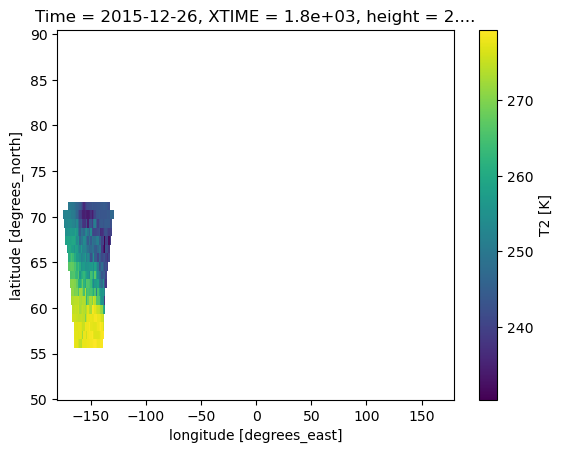

In [4]:
tmp_da = ds["T2"].rename({"XLONG": "lon", "XLAT": "lat"})
era5_common_regridder = xe.Regridder(tmp_da, dst_ds, "bilinear", unmapped_to_nan=True)
regrid = era5_common_regridder(tmp_da, keep_attrs=True)
regrid.isel(Time=0).plot()

### 2. Regrid ERA5 to target grid

We don't have a target grid defined at the moment, so we will make one! We can just use rioxarray to quickly reproject from the stereographic WRF projection to EPSG:3338. Rioxarray is assuredly choosing sane defaults... :)

To do this reprojection, we will load the ancillary "geogrid" file from WRF and compute the grid coordinates by transforming the grid center lat / lon and using the grid shape and pixel size to construct the coordinates.

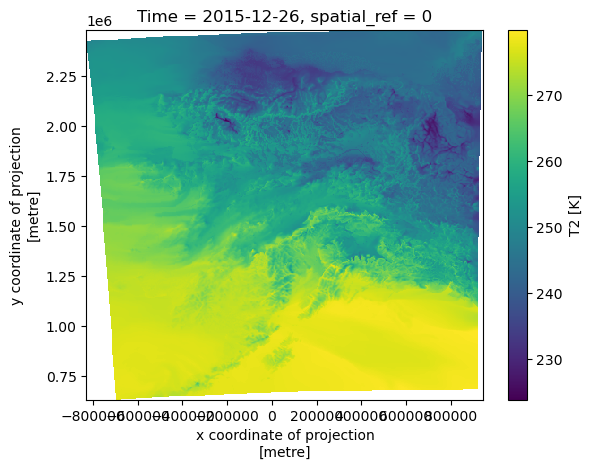

In [5]:
geo_ds = xr.open_dataset("/beegfs/CMIP6/wrf_era5/geo_em.d02.nc")

# The proj4 string for the WRF projection is:
# +proj=stere +units=m +a=6370000.0 +b=6370000.0 +lat_0=90.0 +lon_0=-152 +lat_ts=64 +nadgrids=@null
# this was determined separately using the WRF-Python package
# which has spotty availability / compatability
#
# here is the code for how that was done:
# wrf_proj = PolarStereographic(
#     **{"TRUELAT1": geo_ds.attrs["TRUELAT1"], "STAND_LON": geo_ds.attrs["STAND_LON"]}
# ).proj4()
wrf_proj = "+proj=stere +units=m +a=6370000.0 +b=6370000.0 +lat_0=90.0 +lon_0=-152 +lat_ts=64 +nadgrids=@null"

# WGS84 projection
wgs_proj = Proj(proj="latlong", datum="WGS84")
wgs_to_wrf_transformer = Transformer.from_proj(wgs_proj, wrf_proj)

# this is where we plug in the center longitude of the domain to get the center x, y in projected space
e, n = wgs_to_wrf_transformer.transform(
    geo_ds.attrs["CEN_LON"], geo_ds.attrs["TRUELAT1"]
)
# now compute the rest of the grid based on x/y dimension lengths and grid spacing
dx = dy = 4000
nx = ds.XLONG.shape[1]
ny = ds.XLONG.shape[0]
x0 = -(nx - 1) / 2.0 * dx + e
y0 = -(ny - 1) / 2.0 * dy + n
# 2d grid coordinate values
x = np.arange(nx) * dx + x0
y = np.arange(ny) * dy + y0

wrf_crs = CRS.from_proj4(wrf_proj)
ds_proj = (
    ds["T2"]
    .rename({"south_north": "y", "west_east": "x"})
    .assign_coords({"y": ("y", y), "x": ("x", x)})
    .drop_vars(["XLONG", "XLAT", "XTIME"])
    .rio.set_spatial_dims("x", "y")
    .to_dataset()
    .rio.write_crs(wrf_crs)
)

ds_3338 = ds_proj.rio.reproject("EPSG:3338")
ds_3338.isel(Time=0).T2.plot()

### 3. Resample common grid ERA5 via NN to target 12km 3338 grid

Now that we have our common grid ERA5 as well as ERA5 on our target grid, we can use both to resample the common grid ERA5 to the target grid to get the third product, which is needed for the downscaling. 

In [6]:
# following gergel et al, this ERA5 data on the target grid is called the "fine" version.
# era5_fine = ds_3338_cropped.T2
era5_fine = ds_3338.T2

# wow copilot pretty much nailed it here
# BEGIN: Add irregular lat and lon variables
# Create a transformer from the WRF projection to WGS84
transformer_3338_to_4326 = Transformer.from_crs(3338, 4326)

# Transform the x and y coordinates to lat and lon
xx, yy = np.meshgrid(era5_fine["x"].values, era5_fine["y"].values)
lat, lon = transformer_3338_to_4326.transform(xx, yy)

# Add the lat and lon variables to the dataset
era5_fine = era5_fine.assign_coords(lon=(("y", "x"), lon), lat=(("y", "x"), lat))

Do the regridding:

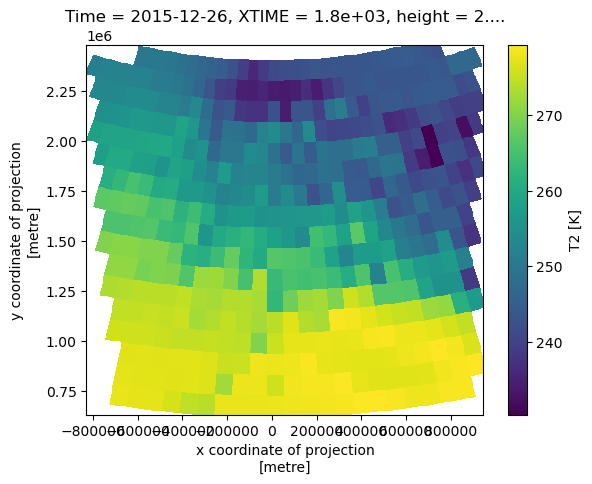

In [7]:
era5_coarse_regridder = xe.Regridder(
    regrid, era5_fine, "nearest_s2d", unmapped_to_nan=True
)
era5_coarse = era5_coarse_regridder(regrid, keep_attrs=True)
era5_coarse.isel(Time=0).plot()

## QDM adjustment

Now we will try first adjusting some GCM data.

From the paper:

> GCM projections for each variable, GCM, experiment, pixel, year, and day at a 1◦ × 1◦ resolution are bias-adjusted using the xclim Python package QDM implementation (Logan et al., 2021). To do this, QDM models for each pixel and day of the year are trained on a rolling 31 d centered window (±15 d) of daily ERA5 and GCM historical data from 1995 to 2014. For ERA5 reference data, we include the last 15 d from 1994 and the first 15 d from 2015, such that each day group contains 620 values (20 years × 31 d). For CMIP6 historical data, since the simulation ends in 2014, we do not include the additional 15 d from 2015 or 1994 for consistency. Each trained QDM model (per pixel and day of year) has 100 equally spaced quantiles in our implementation. We used an additive adjustment for maximum and minimum temperature and a multiplicative adjustment for precipitation. Each variable was bias-adjusted separately.

So, we will first need to load and regrid ERA5 data to the common grid:

In [24]:
from datetime import datetime, timedelta


# Getting all of the files in complete years
fps = []
for year in range(1995, 2015):
    fps.extend(
        sorted(era5_04km_dir.joinpath(f"{year}").glob("era5_wrf_dscale_4km_*.nc"))
    )

# now add the last 15 of 1994 and first 15 of 2015:
# Generate the last 15 days of 1994
last_15_1994 = [
    (datetime(1994, 12, 31) - timedelta(days=i)).strftime("%Y-%m-%d")
    for i in range(14, -1, -1)
]
fps = [
    era5_04km_dir.joinpath(f"1994/era5_wrf_dscale_4km_{ymd_str}.nc")
    for ymd_str in last_15_1994
] + fps

# now the fist 15 days of 2015
first_15_2015 = [
    (datetime(2015, 1, 1) + timedelta(days=i)).strftime("%Y-%m-%d") for i in range(15)
]
fps.extend(
    [
        era5_04km_dir.joinpath(f"2015/era5_wrf_dscale_4km_{ymd_str}.nc")
        for ymd_str in first_15_2015
    ]
)

I think opening all of these files at once might not be the best. 

In [61]:
import dask


def open_and_resample_t2max(fp):
    """Open a single hourly file, resample, and regrid to the coarse grid"""

    ref_day_ds = xr.open_dataset(fp)
    t2max_da = (
        ref_day_ds["T2"]
        .resample(Time="1D")
        .max()
        .rename({"XLONG": "lon", "XLAT": "lat"})
    )

    return t2max_da

In [43]:
regridded_era5 = []
for fp in fps:
    regridded_era5.append(open_and_resample_t2max(fp, era5_common_regridder))

In [63]:
from multiprocessing import Pool
import tqdm

args = [(fp, era5_common_regridder) for fp in fps]

with Pool(26) as pool:

    regridded_era5 = []
    for da in tqdm.tqdm(
        pool.imap_unordered(open_and_resample_t2max, fps), total=len(fps)
    ):
        regridded_era5.append(da)

  8%|████████████▌                                                                                                                                           | 608/7335 [01:55<21:22,  5.24it/s]


KeyboardInterrupt: 

## QPLAD downscaling

Here are some functions pulled from the dodola repo used to set up the CLI pieces for the pipeline workflow. 

In [ ]:
def train_quantiledeltamapping(
    reference, historical, variable, kind, quantiles_n=100, window_n=31
):
    """Train quantile delta mapping

    Parameters
    ----------
    reference : xr.Dataset
        Dataset to use as model reference. Target variable must have a units attribute.
    historical : xr.Dataset
        Dataset to use as historical simulation. Target variable must have a units attribute.
    variable : str
        Name of target variable to extract from `historical` and `reference`.
    kind : {"+", "*"}
        Kind of variable. Used for QDM scaling.
    quantiles_n : int, optional
        Number of quantiles for QDM.
    window_n : int, optional
        Centered window size for day-of-year grouping.

    Returns
    -------
    xclim.sdba.adjustment.QuantileDeltaMapping
    """

    return qdm


def adjust_quantiledeltamapping(
    simulation,
    variable,
    qdm,
    years,
    astype=None,
    quantile_variable="sim_q",
    **kwargs,
):
    """Apply QDM to adjust a range of years within a simulation.

    Parameters
    ----------
    simulation : xr.Dataset
        Daily simulation data to be adjusted. Must have sufficient observations
        around `year` to adjust. Target variable must have a units attribute.
    variable : str
        Target variable in `simulation` to adjust. Adjusted output will
        share the same name.
    qdm : xr.Dataset or sdba.adjustment.QuantileDeltaMapping
        Trained ``xclim.sdba.adjustment.QuantileDeltaMapping``, or Dataset
        representation that will be instantiate
        ``xclim.sdba.adjustment.QuantileDeltaMapping``.
    years : sequence of ints
        Years of simulation to adjust, with rolling years and day grouping.
    astype : str, numpy.dtype, or None, optional
        Typecode or data-type to which the regridded output is cast.
    quantile_variable : str or None, optional
        Name of quantile coordinate to reset to data variable. Not reset
        if ``None``.
    kwargs :
        Keyword arguments passed to
        ``dodola.core.adjust_quantiledeltamapping_year``.

    Returns
    -------
    out : xr.Dataset
        QDM-adjusted values from `simulation`. May be a lazy-evaluated future, not
        yet computed. In addition to adjusted original variables, this includes
        "sim_q" variable giving quantiles from QDM biasadjustment.
    """
    # This loop is a candidate for dask.delayed. Beware, xclim had issues with saturated scheduler.
    qdm_list = []
    for yr in years:
        adj = adjust_quantiledeltamapping_year(
            simulation=simulation, qdm=qdm, year=yr, variable=variable, **kwargs
        )
        if astype:
            adj = adj.astype(astype)
        qdm_list.append(adj)

    # Combine years and ensure output matches input data dimension order.
    adjusted_ds = xr.concat(qdm_list, dim="time").transpose(*simulation[variable].dims)

    if quantile_variable:
        adjusted_ds = adjusted_ds.reset_coords(quantile_variable)
        # Analysts said sim_q needed no attrs.
        adjusted_ds[quantile_variable].attrs = {}

    # Overwrite QDM output attrs with input simulation attrs.
    adjusted_ds.attrs = simulation.attrs
    for k, v in simulation.variables.items():
        if k in adjusted_ds:
            adjusted_ds[k].attrs = v.attrs

    return adjusted_ds


def train_analogdownscaling(
    coarse_reference, fine_reference, variable, kind, quantiles_n=620, window_n=31
):
    """Train Quantile-Preserving, Localized Analogs Downscaling (QPLAD)

    Parameters
    ----------
    coarse_reference : xr.Dataset
        Dataset to use as resampled (to fine resolution) coarse reference.Target variable must have a units attribute.
    fine_reference : xr.Dataset
        Dataset to use as fine-resolution reference. Target variable must have a units attribute.
    variable : str
        Name of target variable to extract from `coarse_reference` and `fine_reference`.
    kind : {"+", "*"}
        Kind of variable. Used for creating QPLAD adjustment factors.
    quantiles_n : int, optional
        Number of quantiles for QPLAD.
    window_n : int, optional
        Centered window size for day-of-year grouping.

    Returns
    -------
    xclim.sdba.adjustment.QuantilePreservingAnalogDownscaling
    """

    # QPLAD method requires that the number of quantiles equals
    # the number of days in each day group
    # e.g. 20 years of data and a window of 31 = 620 quantiles

    # check that lengths of input data are the same, then only check years for one
    if len(coarse_reference.time) != len(fine_reference.time):
        raise ValueError("coarse and fine reference data inputs have different lengths")

    # check number of years in input data (subtract 2 for the +/- 15 days on each end)
    num_years = len(np.unique(fine_reference.time.dt.year)) - 2
    if (num_years * int(window_n)) != quantiles_n:
        raise ValueError(
            "number of quantiles {} must equal # of years {} * window length {}, day groups must {} days".format(
                quantiles_n, num_years, int(window_n), quantiles_n
            )
        )

    qplad = sdba.adjustment.QuantilePreservingAnalogDownscaling.train(
        ref=coarse_reference[variable],
        hist=fine_reference[variable],
        kind=str(kind),
        group=sdba.Grouper("time.dayofyear", window=int(window_n)),
        nquantiles=quantiles_n,
    )
    return qplad


def adjust_analogdownscaling(simulation, qplad, variable):
    """Apply QPLAD to downscale bias corrected output.

    Parameters
    ----------
    simulation : xr.Dataset
        Daily bias corrected data to be downscaled. Target variable must have a units attribute.
    qplad : xr.Dataset or sdba.adjustment.QuantilePreservingAnalogDownscaling
        Trained ``xclim.sdba.adjustment.QuantilePreservingAnalogDownscaling``, or
        Dataset representation that will instantiate
        ``xclim.sdba.adjustment.QuantilePreservingAnalogDownscaling``.
    variable : str
        Target variable in `simulation` to downscale. Downscaled output will share the
        same name.

    Returns
    -------
    out : xr.Dataset
        QPLAD-downscaled values from `simulation`. May be a lazy-evaluated future, not
        yet computed.
    """
    variable = str(variable)

    if isinstance(qplad, xr.Dataset):
        qplad = sdba.adjustment.QuantilePreservingAnalogDownscaling.from_dataset(qplad)

    out = qplad.adjust(simulation[variable]).to_dataset(name=variable)

    out = out.transpose(*simulation[variable].dims)
    # Overwrite QPLAD output attrs with input simulation attrs.
    out.attrs = simulation.attrs
    for k, v in simulation.variables.items():
        if k in out:
            out[k].attrs = v.attrs

    return out